# Helpful (hopefully) notes and general measurement tips

- **Spectrum Analyzer:** The spectrum analyzer tends to timeout if it hasn't been used in a while. To restart it, simply execute the qubit initialization again or use the qb._instrument.set() command to send a value and wake the instrument back up.
- 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from qubit import qubit
import numpy as np
import plot_functions as pf
# from instrument_init import init_sa

# Initialize qubit

In [ ]:
qb = qubit('ocs6')

# Time of flight

For tof calibration, we don't need the resontor frequency per se

In [ ]:
qb.update_value('readout_atten',0)
qb.update_value('tof',56) #clock cycles
qb.update_value('smearing',10)
qb.update_value('n_avg',1000)
qb.update_value('rr_IF',5e6) 
qb.update_value('readout_length',1000)

adc1,adc2 = qb.tof_cal(update_tof=True)
pf.tof_plot(adc1, adc2,delay=qb.pars['tof'],offsets=qb.pars['analog_input_offsets'])

In [ ]:
adc1,adc2 = qb.tof_cal(update_tof=True)
pf.tof_plot(adc1, adc2,delay=qb.pars['tof'],offsets=qb.pars['analog_input_offsets'])

**Note:** execute the following cell to visually see if the tof is calibrated

2024-04-05 16:07:11,322 - qm - INFO     - Performing health check
2024-04-05 16:07:11,335 - qm - INFO     - Health check passed
2024-04-05 16:07:11,698 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 16:07:11,735 - qm - INFO     - Executing program
Input 1 Offset: 0.07672060780316235 mV
Input 2 Offset: -0.11302101165649901 mV
Updating analog_input_offsets to [0.03792003714276485, 0.07340324288305572]


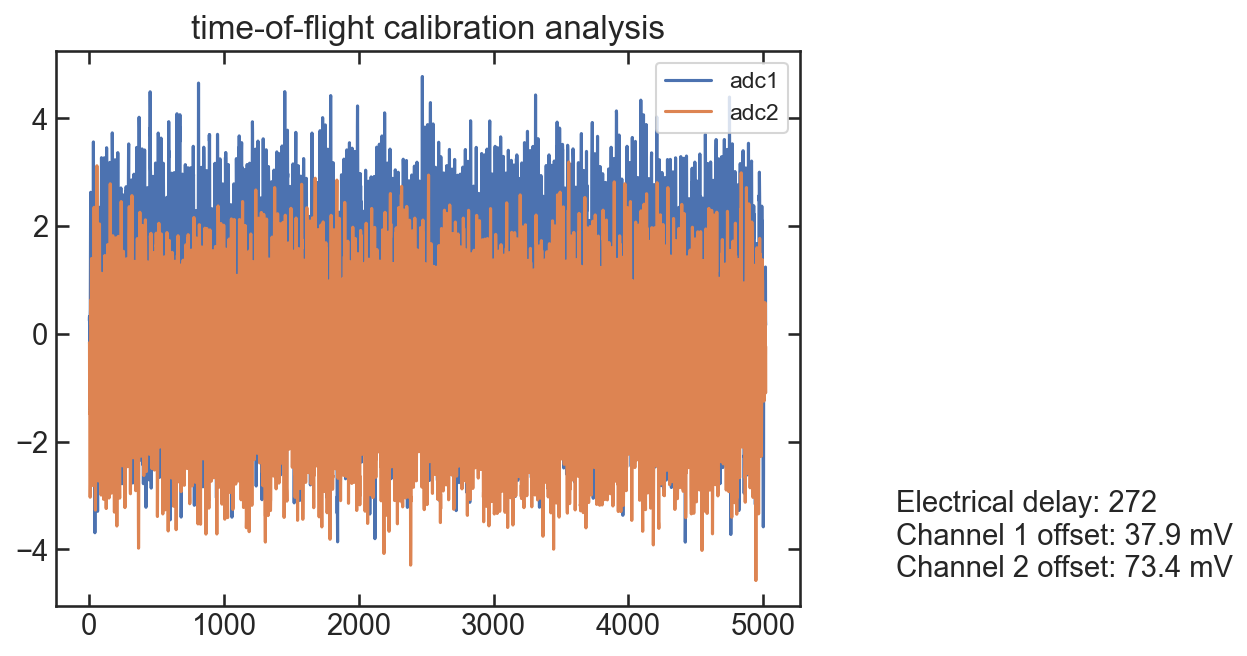

In [139]:
adc1,adc2 = qb.tof_cal(update_tof=False)
pf.tof_plot(adc1, adc2,delay=qb.pars['tof'],offsets=qb.pars['analog_input_offsets'])

# Optimize Mixers

Starting with the smallest resonator

In [ ]:
LO_freq = 8.59e9 #Hz (targets the smallest resonator)

## Minimize LO leakage 

In [ ]:
qb.update_value('rr_LO',LO_freq)
# qb.get_power(fc=qb.pars['rr_LO'],threshold=-20,span=1e6,config=True,plot=True)
qb.opt_lo_leakage(mode='coarse',element='rr',sa_span=0.5e6,threshold=-20,plot=True)

## Minimize image sideband

In [ ]:
qb.update_value('rr_IF',50e6)
qb.opt_sideband(mode='coarse',element='rr',sa_span=0.5e6,threshold=-20,plot=True)

In [ ]:
qb.opt_sideband(mode='coarse',element='rr',sa_span=0.5e6,threshold=-50,plot=True)

# Resonator spectroscopy

**Notes on resonator spectroscopy**

In [ ]:
IF_min, IF_max = 30e6, 40e6

In [150]:
qb.update_value('readout_length', 5000)   #ns (since resonator is narrow)
qb.pars['resettime']['rr'] = 20000 #ns
qb.write_pars()
qb.update_value('n_avg',50)
qb.update_value('readout_atten',10)
df_resonator_spec = 0.025e6
qb.experiment = 'resonator_spec'
##added a 10db fixed attenuator on rr line after the spiltter and just before fridge input
data, job = qb.resonator_spec(
                       f_LO = qb.pars['rr_LO'],
                       IF_min = IF_min,
                       IF_max = IF_max,
                       df = df_resonator_spec,
                       fit=True,
                       on_off=False,
                       savedata=True,
                       showprogress=True)

Updating readout_length to 5000
Updating n_avg to 50
Updating readout_atten to 10
Setting DA attenuation to 10.
Updating rr_LO to 8590000000.0
Setting readout_LO frequency to 8590000000.0.
20000
2024-04-05 16:29:47,441 - qm - INFO     - Performing health check
2024-04-05 16:29:47,453 - qm - INFO     - Health check passed
2024-04-05 16:29:48,176 - qm - INFO     - Sending program to QOP for compilation
2024-04-05 16:29:48,291 - qm - INFO     - Executing program


 98%|█████████▊| 49/50 [00:02<00:00, 23.69it/s]


Saving data to G:\Shared drives\CavityCooling\DARPA\data\darpa2A\20240405\resonator_spec\rr
iteration: 1
metadata: {'date/time': datetime.datetime(2024, 4, 5, 16, 29, 50, 599734), 'nAverages': 50, 'w_LO': 8590000000.0, 'wait_period': 20000}
data: {'I': array([ 4.11408618e-04,  4.34289873e-04,  2.67030671e-04,  2.76608616e-04,
        2.36949846e-04,  1.51588097e-04,  1.63504109e-04,  1.52685791e-04,
        3.88743728e-05,  8.29816610e-05,  4.65899706e-05,  1.05600283e-04,
        5.65759838e-06, -4.47613001e-05, -3.94629687e-05, -1.00359693e-04,
       -1.09091550e-04, -8.28039646e-05, -1.40598416e-04, -2.28738561e-04,
       -2.67542228e-04, -3.10058594e-04, -3.18424180e-04, -3.56047973e-04,
       -3.76381949e-04, -3.43106240e-04, -3.83476540e-04, -4.72747982e-04,
       -4.61731181e-04, -5.20074368e-04, -5.40270880e-04, -5.09556979e-04,
       -5.61674908e-04, -5.50563261e-04, -6.41396120e-04, -5.84506765e-04,
       -6.47644699e-04, -6.39617518e-04, -6.52862340e-04, -6.88564107e-0

Resonant Frequency: 8.62310 GHz
FWHM = 0.35 MHz
kappa = 2.199 MHz


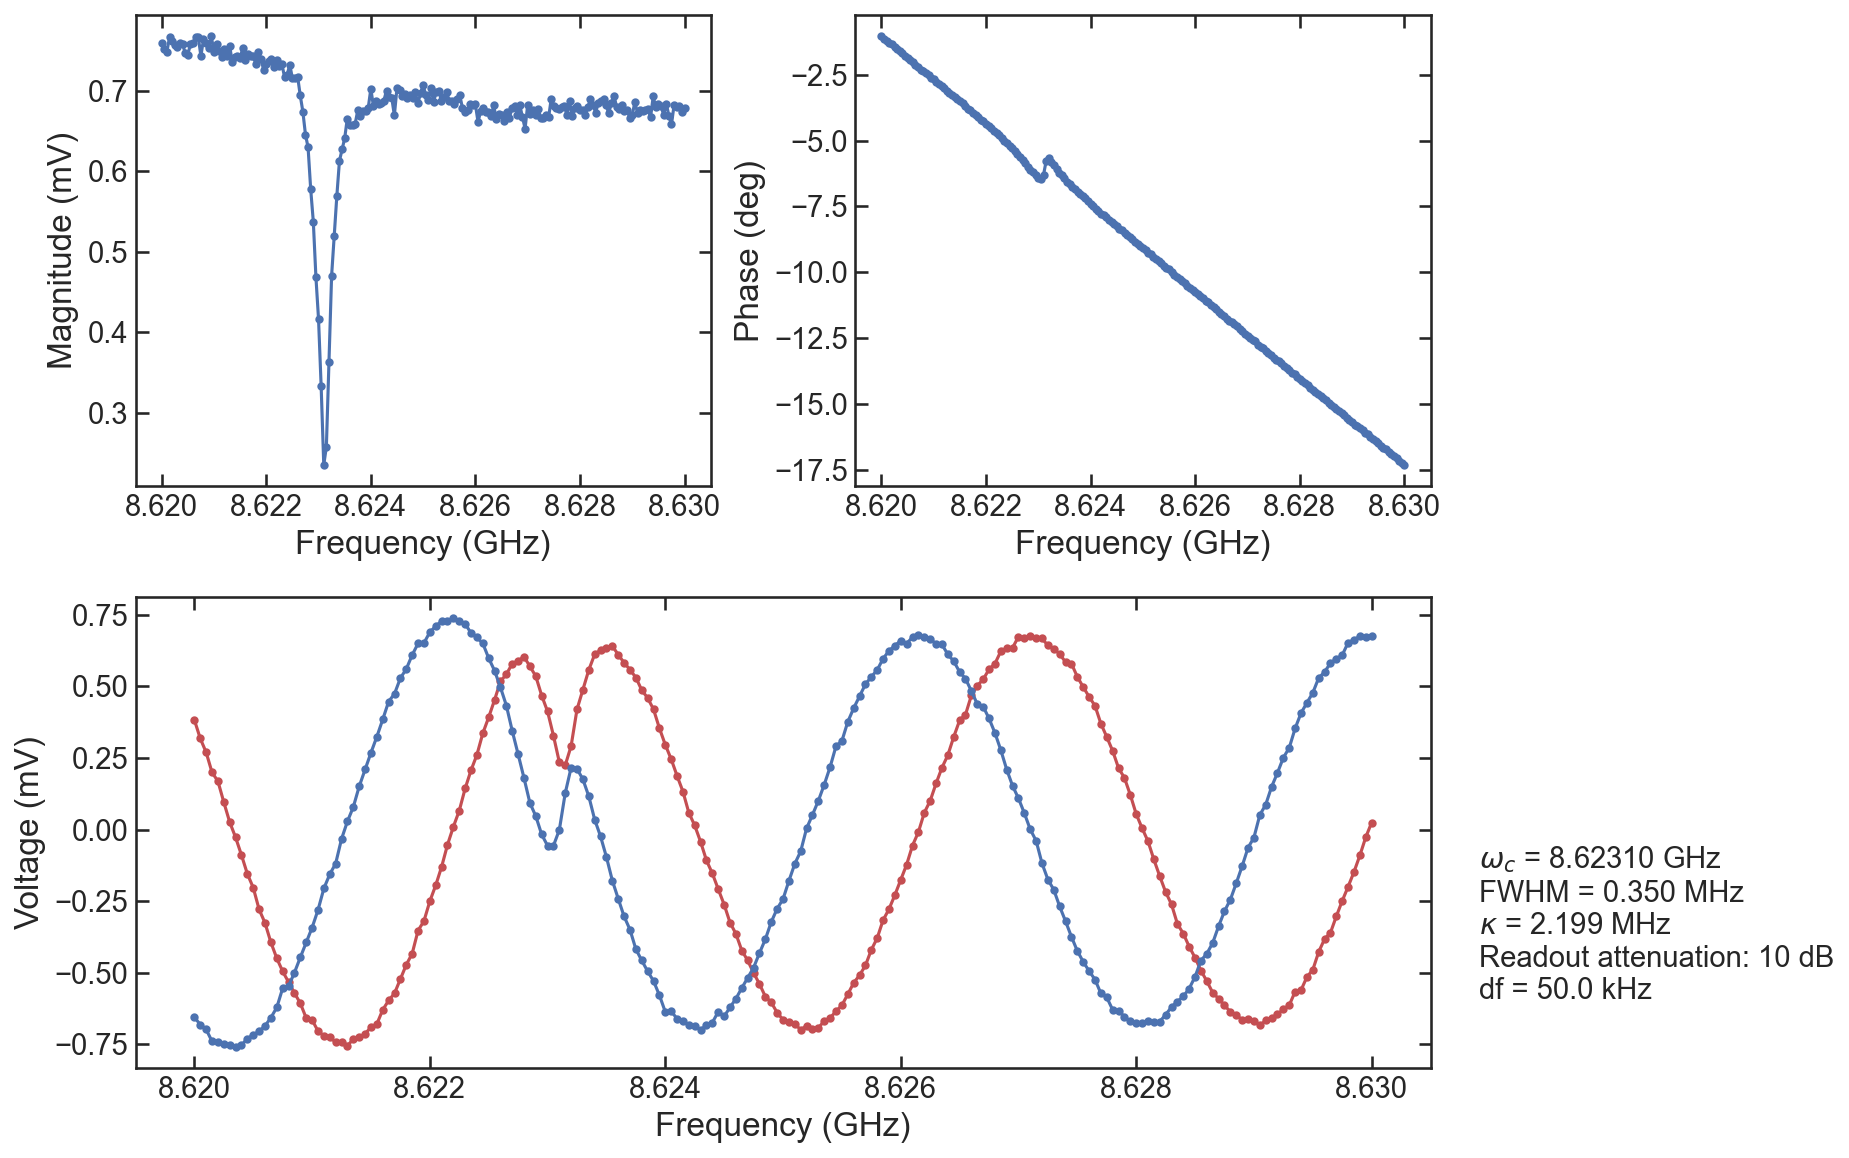

In [ ]:
fc,fwhm = pf.fit_res(data['freqs'],data['I'],data['Q'])
pf.resonator_spec_plot(data,qb_pars=qb.pars,fwhm=fwhm,fc=fc)

# Qubit Punchout

In [ ]:
attenuations = np.arange(0,40,10)
qb.update_value('n_avg',1100)
data, job = qb.punchout(df = 0.1e6,
                 IF_min = IF_min,
                 IF_max = IF_max,
                 attenuations=attenuations,
                 savedata=False)

In [ ]:
pf.punchout_plot(data,xlabel='Frequency (GHz)',ylabel='Attenuation (dB)',cbar_label='Magnitude (dBm)')

# Qubit Spectroscopy

In [ ]:
amp_q_scaling = 0.1
qb.update_value('n_avg',5000)
qb.update_value('rr_freq', 6.465e9)
# qb.update_value('rr_IF', 50e6)
# qb.update_value('smearing',40)
# qb.update_value('tof',292)
qb.update_value('readout_atten',24)
qb.update_value('rr_LO', qb.pars['rr_freq'] - qb.pars['rr_IF'])
qb.pars['resettime']['qubit'] = int(20e3)
qb.write_pars()
qb.experiment = 'qubit_spec'
data, job = qb.qubit_spec(element='qubit',
                                check_mixers=False,
                                IF_min=70e6,
                                IF_max=85e6,
                                f_LO=6e9,
                                df=0.1e6,
                                on_off=True,
                                amp_q_scaling = amp_q_scaling,
                                saturation_dur = 20e3,
                                showprogress=True,
                                savedata=False)

In [ ]:
pf.qubit_spec_plot(data,qb_pars=qb.pars,find_peaks=True, amp_q_scaling=amp_q_scaling)

## Run broad spectroscopy scan on qubit

In [ ]:
qb._instruments.set('sa','frequency',6e9)

In [ ]:
qb.update_value('n_avg',5000)
qb.update_value('rr_freq', 6.464e9) #low power resonator
qb.update_value('rr_IF', 50e6)
qb.update_value('rr_LO', qb.pars['rr_freq'] - qb.pars['rr_IF'])
qb.pars['resettime']['qubit'] = int(20e3)
qb.write_pars()
df_qubit_spec = 2e6
data, job = qb.run_scan(df = df_qubit_spec, element='qubit',
                                check_mixers=False,
                                chunksize = 200e6,
                                lo_min = 5e9,
                                lo_max = 6e9,
                                amp_q_scaling = 1,
                                on_off=True,
                                saturation_dur = 20e3,                   
                                showprogress=True,
                                savedata=False)

In [ ]:
pf.qubit_spec_plot(data,qb_pars=qb.pars,df=df_qubit_spec,rrFreq=qb.pars['rr_freq'],amp_q_scaling=1)